In [2]:
import numpy as np
import pandas as pd

In [3]:
# Load the preprocessed dataset
data_preped = pd.read_csv(r"C:\Users\Megha\jupyter\Solar-irradiance-code-files\data.csv")

"""
This script reads data from 'data.csv'.
Ensure the folder structure is:
- DR-LSTM.ipynb
- data.csv
"""

## STEP 1: Prepare the Data for LSTM

In [3]:
data_preped.columns

Index(['year', 'month', 'day', 'ALLSKY_SFC_SW_DWN', 'T2M', 'CLOUD_AMT', 'RH2M',
       'HR_SIN', 'HR_COS', 'DAY_SIN', 'DAY_COS', 'SEASON_Autumn',
       'SEASON_Monsoon', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Winter'],
      dtype='object')

In [4]:
data_preped.head()

,year,month,day,ALLSKY_SFC_SW_DWN,T2M,CLOUD_AMT,RH2M,HR_SIN,HR_COS,DAY_SIN,DAY_COS,SEASON_Autumn,SEASON_Monsoon,SEASON_Spring,SEASON_Summer,SEASON_Winter
0,2020,1,1,0.0,0.129363,0.7876,0.546526,0.000000,1.000000,0.974928,-0.222521,0,0,0,0,1
1,2020,1,1,0.0,0.114784,0.9109,0.573478,0.258819,0.965926,0.974928,-0.222521,0,0,0,0,1
2,2020,1,1,0.0,0.104723,0.8085,0.592334,0.500000,0.866025,0.974928,-0.222521,0,0,0,0,1
3,2020,1,1,0.0,0.095893,0.5953,0.611293,0.707107,0.707107,0.974928,-0.222521,0,0,0,0,1
4,2020,1,1,0.0,0.089733,0.5087,0.622976,0.866025,0.500000,0.974928,-0.222521,0,0,0,0,1


## STEP 2: Defining X and Y: features and Target
#### Features (X):
* T2M (Temperature at 2 meters)
* CLOUD_AMT (Cloud cover percentage)
* RH2M (Relative humidity at 2 meters)
* DAY_OF_WEEK (Day of the week)
* HR or HOUR (Hour of the day)
* SEASON (Season of the year)

#### Target (y):
* ALLSKY_SFC_SW_DWN (Solar Irradiance)

In [5]:
# Define features and target
features = ['T2M', 'CLOUD_AMT', 'RH2M', 'HR_SIN', 'HR_COS', 'DAY_SIN', 'DAY_COS'] + \
           [col for col in data_preped.columns if col.startswith('SEASON_')]
target = 'ALLSKY_SFC_SW_DWN'

# Extract features and target
X = data_preped[features].values
y = data_preped[target].values

## STEP 3: Create Sequences for LSTM

In [6]:
def create_sequences(X, y, time_step=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_step):
        X_seq.append(X[i:(i + time_step)])
        y_seq.append(y[i + time_step])
    return np.array(X_seq), np.array(y_seq)

# Define the time step (e.g., 24 hours)
time_step = 24

# Create sequences
X_seq, y_seq = create_sequences(X, y, time_step)

## STEP 4: Split the Data into Training and Testing Sets

In [8]:
# Define train-validation-test split ratio
train_size = int(len(X_seq) * 0.7)  # 70% for training
val_size = int(len(X_seq) * 0.15)   # 15% for validation
test_size = len(X_seq) - train_size - val_size  # Remaining 15% for testing

In [9]:
# Split the data into training, validation, and testing sets
X_train, X_val, X_test = X_seq[:train_size], X_seq[train_size:train_size+val_size], X_seq[train_size+val_size:]
y_train, y_val, y_test = y_seq[:train_size], y_seq[train_size:train_size+val_size], y_seq[train_size+val_size:]

## STEP 5: Build the LSTM Model

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    # First LSTM layer
    LSTM(64,
         input_shape=(X_train.shape[1], X_train.shape[2]),
         return_sequences=True,
         kernel_regularizer=l2(0.01)), # Increased L2
    BatchNormalization(),
    Dropout(0.4), # Increased Dropout

    # Second LSTM layer (optional - consider removing or reducing units)
    LSTM(32, kernel_regularizer=l2(0.01)), # Added L2
    Dropout(0.3), # Increased Dropout

    # Dense layers
    Dense(16, activation='relu', kernel_regularizer=l2(0.005)), # Reduced units, added L2
    Dense(1) # Linear activation for regression
])

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001) # Reduced learning rate
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_mae',
                               patience=10, # Stop after 10 epochs of no improvement
                               restore_best_weights=True)


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            19712     
                                                                 
 batch_normalization (BatchN  (None, 24, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                        

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=20, # Or more, early stopping will handle it
    batch_size=32, # Experiment with batch size
    validation_data=(X_val, y_val), # Make sure you have a validation set
    callbacks=[early_stopping]
)

Epoch 1/20
879/879 [==============================] - 21s 19ms/step - loss: 0.9677 - mae: 0.1994 - val_loss: 0.6188 - val_mae: 0.0798
Epoch 2/20
879/879 [==============================] - 16s 18ms/step - loss: 0.4366 - mae: 0.1046 - val_loss: 0.2758 - val_mae: 0.0539
Epoch 3/20
879/879 [==============================] - 15s 17ms/step - loss: 0.1961 - mae: 0.0742 - val_loss: 0.1269 - val_mae: 0.0474
Epoch 4/20
879/879 [==============================] - 14s 16ms/step - loss: 0.0932 - mae: 0.0593 - val_loss: 0.0621 - val_mae: 0.0455
Epoch 5/20
879/879 [==============================] - 14s 16ms/step - loss: 0.0474 - mae: 0.0529 - val_loss: 0.0325 - val_mae: 0.0446
Epoch 6/20
879/879 [==============================] - 14s 16ms/step - loss: 0.0258 - mae: 0.0479 - val_loss: 0.0187 - val_mae: 0.0429
Epoch 7/20
879/879 [==============================] - 14s 16ms/step - loss: 0.0160 - mae: 0.0450 - val_loss: 0.0129 - val_mae: 0.0408
Epoch 8/20
879/879 [==============================] - 17s 20ms

## STEP 7: Visualize Metrics:

### 1. Training and Validation Loss (MSE)

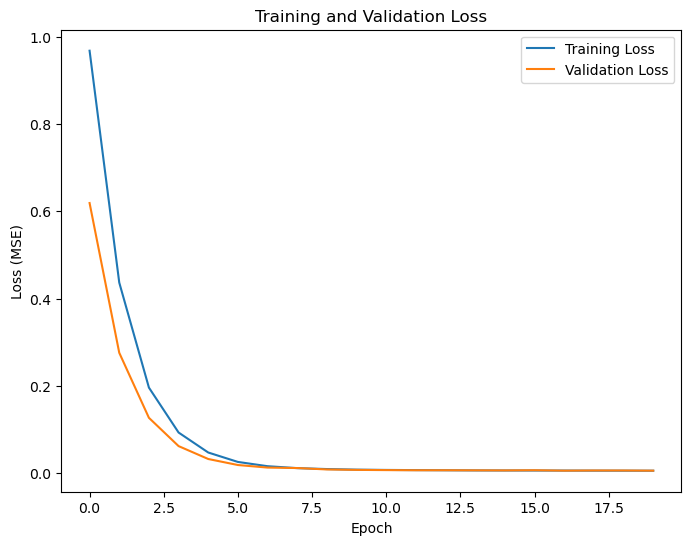

In [14]:
# Plot training and validation loss
import matplotlib.pyplot as plt
# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 2. Training and Validation MAE

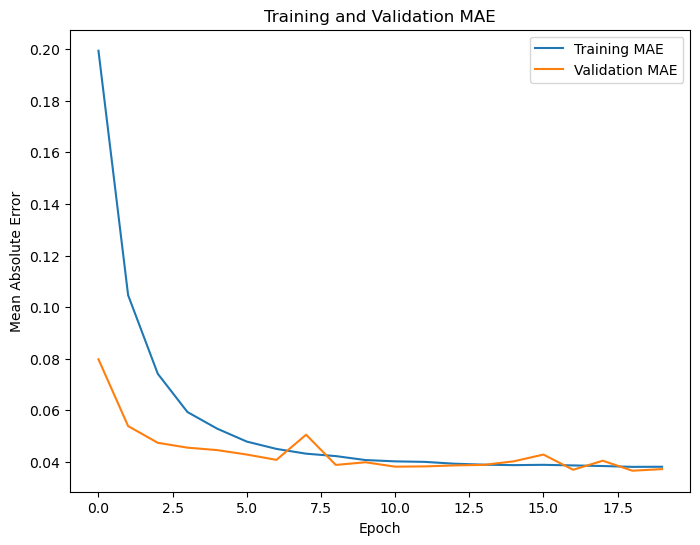

In [15]:
# Plot training and validation MAE
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

### 3. Actual vs. Predicted Values

189/189 [==============================] - 1s 6ms/step


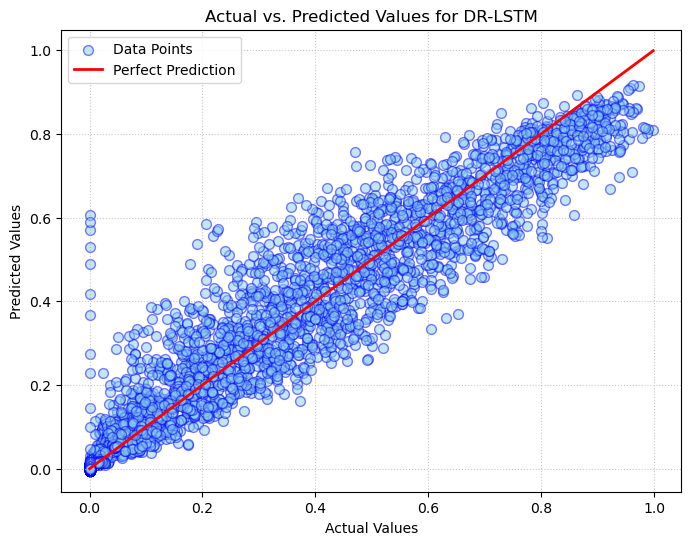

In [17]:
# Make predictions on the test set
y_pred = model.predict(X_test)  # No need for scaler.inverse_transform()

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred,
            s=50,             # Slightly larger markers
            alpha=0.5,        # Good transparency to show density
            color='skyblue',  # A pleasant color for the points
            edgecolors='blue', # Darker edge for better definition
            label='Data Points')  # No need for scaler.inverse_transform()
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
# Add a grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)
# Add a legend
plt.legend(fontsize=10)
plt.title('Actual vs. Predicted Values for DR-LSTM')
plt.show()

### 4. Residual Plot

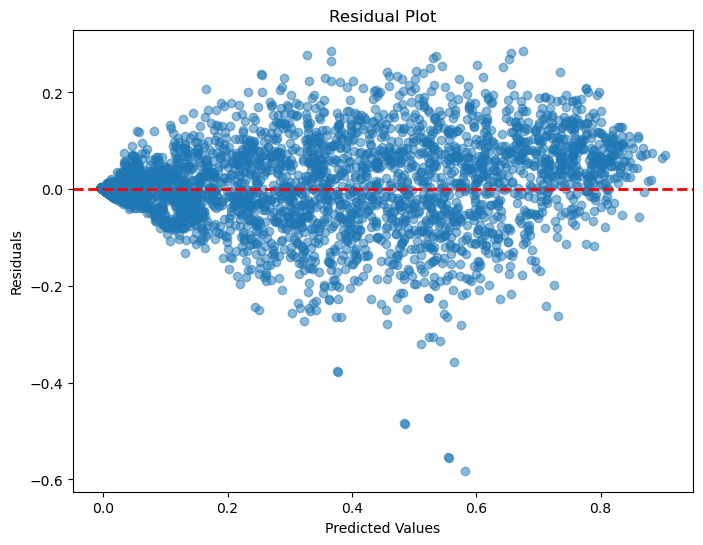

In [18]:
# Calculate residuals
residuals = y_test - y_pred.flatten()

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## STEP 8: Computing other matrices (RMSE, MAE, R-squared)

In [19]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Calculate MAE
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

# Calculate R-squared
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

RMSE: 0.06653511682053083
MAE: 0.03668688392585912
R-squared: 0.9400351206325859


In [21]:
# Calculate 1-Hour MAE for next-step prediction
one_hour_mae = mean_absolute_error(y_test, y_pred)
print(f"1-Hour MAE: {one_hour_mae:.4f}")

1-Hour MAE: 0.0367
